# Overview

While learning about options and other derivatives, I started this project to get a better understanding of how pricing models work. As someone who learns best through building and breaking things, this was an attempt to build (and sometimes break) the theory presented in *Options, Futures, and Other Derivatives* by *John C. Hull*.

I first began by implementing Monte Carlo (MC) and Black Scholes (BS) models for vanilla European options (Section 1). Then, I used Implied Volatility (IV) data to compare the actual market price of American equity options with that predicted by the MC and BS models (Section 2).

Afterwhich, I attempted to generate a volatility smile and compare that to what is theoretically expected (Section 3). Lastly, I plotted historical volatility against implied volatility and tried to correlate the graph to major events affecting the underlying equity (Section 4).

In [69]:
#Import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Data

The historical price data and IV data was downloaded from a [Kaggle Dataset](https://www.kaggle.com/datasets/kylegraupe/aapl-options-data-2016-2020/discussion?sort=hotness)  .

I chose AAPL due to its high liquidity and frequent use in options trading. I was able to obtain historical option chain data from 2016 - 2019 & Jan 2021 - Apr 2023.

AAPL had a stock split on Aug 31st 2020, which was announced a month earlier on Jul 30th 2020. To avoid the effects of this from complicating what should be a simple analysis, we avoid data from this duration.

Therefore, I will only be looking at data from **Jan 2021 onwards**. 

### Data Wrangling and Cleaning

First, we determine the types of data available in our dataset, then filter to get the relevant data. We then convert the datatypes into the required types.

In [30]:
# Options chain data
df_chain = pd.read_csv('data/AAPL_Options_Chain.csv')
print(df_chain.columns)

C:\Users\asaad\AppData\Local\Temp\ipykernel_20264\805936958.py:2: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_chain = pd.read_csv('data/AAPL_Options_Chain.csv')


Index(['[QUOTE_UNIXTIME]', ' [QUOTE_READTIME]', ' [QUOTE_DATE]',
       ' [QUOTE_TIME_HOURS]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]',
       ' [EXPIRE_UNIX]', ' [DTE]', ' [C_DELTA]', ' [C_GAMMA]', ' [C_VEGA]',
       ' [C_THETA]', ' [C_RHO]', ' [C_IV]', ' [C_VOLUME]', ' [C_LAST]',
       ' [C_SIZE]', ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [P_BID]',
       ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]',
       ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]',
       ' [STRIKE_DISTANCE]', ' [STRIKE_DISTANCE_PCT]'],
      dtype='object')


In [52]:
#We select the relevant columns and convert the data types into the types we expect them to be
columns_of_interest = [' [UNDERLYING_LAST]', ' [QUOTE_DATE]', ' [EXPIRE_DATE]', ' [DTE]', ' [STRIKE]', ' [C_ASK]', ' [C_BID]', ' [C_IV]', ' [P_ASK]', ' [P_BID]',
      ' [P_IV]']
df_chain = df_chain[columns_of_interest]

#correct data types
df_chain[' [QUOTE_DATE]'] = pd.to_datetime(df_chain[' [QUOTE_DATE]'])
df_chain[' [EXPIRE_DATE]'] = pd.to_datetime(df_chain[' [EXPIRE_DATE]'])

#The following columns had non-floats in them, therefore there is a need to convert these entries into NaNs to allow imputation later
columns_to_fix = [' [C_ASK]',' [C_BID]', ' [C_IV]' ,' [P_ASK]',  ' [P_BID]',' [P_IV]' ]
for col in columns_to_fix:
    df_chain[col] = pd.to_numeric(df_chain[col], errors = 'coerce')
    df_chain[col] = np.where(df_chain[col].apply(lambda x: isinstance(x, float)), df_chain[col].astype('float'), np.nan)

#A quick check using df_chain.info() shows that all datatypes are now consistent with what we expect them to be
df_chain.info() # To get info about the datatypes in each column



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548163 entries, 0 to 548162
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0    [UNDERLYING_LAST]  548163 non-null  float64       
 1    [QUOTE_DATE]       548163 non-null  datetime64[ns]
 2    [EXPIRE_DATE]      548163 non-null  datetime64[ns]
 3    [DTE]              548163 non-null  float64       
 4    [STRIKE]           548163 non-null  float64       
 5    [C_ASK]            417091 non-null  float64       
 6    [C_BID]            547968 non-null  float64       
 7    [C_IV]             518320 non-null  float64       
 8    [P_ASK]            547968 non-null  float64       
 9    [P_BID]            547968 non-null  float64       
 10   [P_IV]             503463 non-null  float64       
dtypes: datetime64[ns](2), float64(9)
memory usage: 46.0 MB


In [65]:
#We still need to determine how much of our data is missing/cannot be used
print(r"Missing/Wrong data % in each column")
(df_chain.isna().sum()/df_chain.count())*100

#Running the next cell and running this cell again confirms that we have gotten rid of all the mess present in the data

Missing/Wrong data % in each column


[UNDERLYING_LAST]    0.0
[QUOTE_DATE]         0.0
[EXPIRE_DATE]        0.0
[DTE]                0.0
[STRIKE]             0.0
[C_ASK]              0.0
[C_BID]              0.0
[C_IV]               0.0
[P_ASK]              0.0
[P_BID]              0.0
[P_IV]               0.0
dtype: float64

In [ ]:
# We will need to fix this - lets see how much data we have left after dropping NaN rows
df_chain = df_chain.dropna()

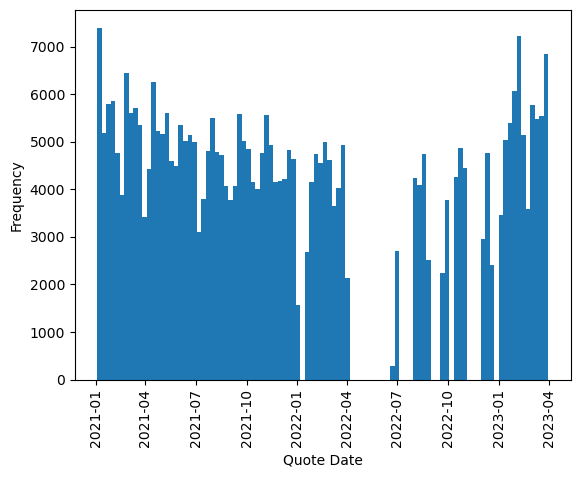

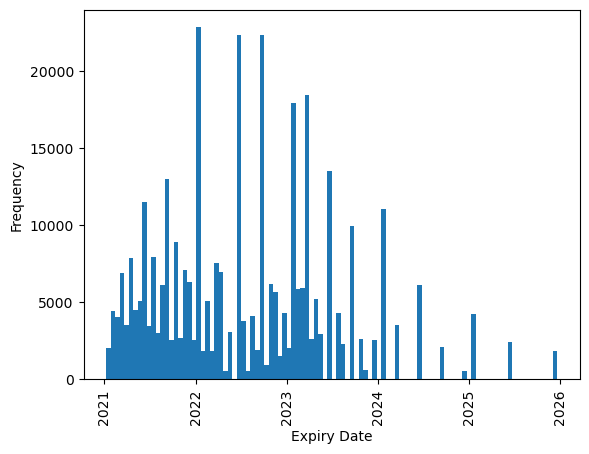

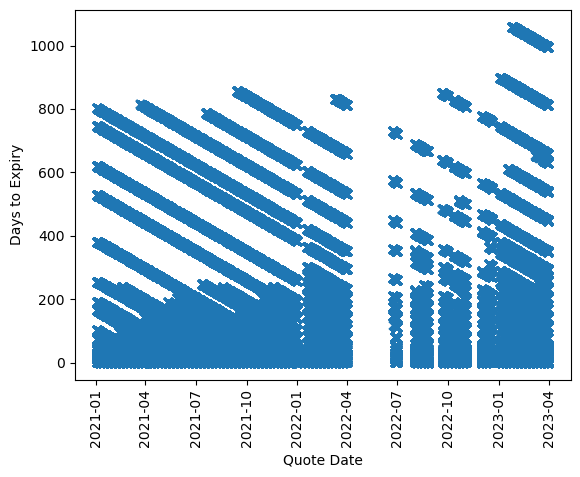

In [158]:
plt.hist(df_chain[' [QUOTE_DATE]'], bins= 100)
plt.xticks(rotation = 90)
plt.xlabel("Quote Date")
plt.ylabel("Frequency")
plt.show()


plt.scatter(df_chain[' [QUOTE_DATE]'], df_chain[' [DTE]'], marker='x')
plt.xticks(rotation = 90)
plt.xlabel("Quote Date")
plt.ylabel("Days to Expiry")
plt.show()

Looking at the plot above we can see that there is are a few options issued in 2021/01 that were exercised within the year. The data in this period also appears to be uninterruped by the data cleaning we have done so far. Therefore, I'll use this date range. Now that our data is ready we can proceed with analysis.

# Section 1: Pricing Models

## MC Pricing Model

In this section, I implement the pricing Monte Carlo (MC) model shown in [1]: 
$$ \begin{align}
S(t+\Delta t)-S(t)=\hat{\mu} S(t) \Delta t+\sigma S(t) \epsilon \sqrt{\Delta t}
\end{align}$$
Here:
* S: Current Price
* T: Time to maturity (years)
* K: Strike Price
* r: Risk free rate
* sigma: IV

I referred to the implementation in [2] for both the MC and Black Scholes model, but optimised the MC model using Numpy vectorisation. The convention stated here is also used for the BS model.

In [72]:
def MC_pricing(S, T, K, r, sigma, mc_step_count, simulation_count, type):
    """
    S: Current price
    T: Time to maturity
    K: Strike Price
    r: Risk free rate
    sigma: volatility
    """
    #Each time a price is generated a we will run 10000 simulations
    #Each simulation requires iterative multiplication of the current time steps' price by the updated exponential factor
    #We try and vectorise the simulations, but run the iterative multiplication with an explicit loop
    price_paths = np.full((simulation_count, mc_step_count+1), S)


    time_step = T/mc_step_count
    e = np.random.standard_normal(size=(simulation_count, mc_step_count)) # A sim count x mc step count array

    expoential_factor = np.exp((r - (sigma**2)/2)*time_step
                               + sigma * e * np.sqrt(time_step)
                               )                                    #This produces an sim count x mc step count array of expoential factors


    # We need to set all columns except the first one to be equal to the S times the cum product of the exponential factors array
    price_paths[:, 1:] = S *np.cumprod(expoential_factor, axis=1) # multiply along the row
    final_prices = price_paths[:, -1]

    if type == 'call':
        pay_off =  np.maximum(final_prices - K, 0)

    elif type == 'put':
        pay_off =  np.maximum(K - final_prices, 0)

    option_price = np.mean(pay_off)*np.exp(-r * T)

    return option_price


## Black Scholes Pricing Model

This is an implementation of the following equations from [1]
$$\begin{align}
&\text{Call Option Value}: S_0 N\left(d_1\right)-K e^{-r T} N\left(d_2\right) \\
&\text{Put Option Value}: K e^{-r} T\left(-d_2\right)-S N\left(-d_1\right)
\end{align}$$

where $$\begin{aligned}
& d_1=\frac{\ln \left(S_0 / K\right)+\left(r+\sigma^2 / 2\right) T}{\sigma \sqrt{T}} \\
& d_2=\frac{\ln \left(S_0 / K\right)+\left(r-\sigma^2 / 2\right) T}{\sigma \sqrt{T}}=d_1-\sigma \sqrt{T}
\end{aligned}$$

and 

* $e^{-r T}:$ Present value factor
* $N\left(d_2\right): \quad$ Probability of exercise
* $S_0 e^{r T} N\left(d_1\right) / N\left(d_2\right): \quad$ Expected stock price in a risk-neutral world if option is exercised
* $K: \quad$ Strike price paid if option is exercised.

In [99]:
def black_scholes_price(S,T, K,r,sigma,type):
    """
    Taken from [1]
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # call_price = value of the option 
    """
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    
    if type == 'call':
        
        call = S * np.exp(-r*T)* norm.cdf(d1) - K * np.exp(-r*T)* norm.cdf(d2)
        return call
    
    elif type == 'put':
         put = K * np.exp(-r * T) * norm.cdf(-d2) - S *norm.cdf(-d1)
         return put

## Comparision of both models
We can verify to some extent whether these models are correctly implemented by seeing if they behave like we would expect them to under changing volatility and risk free rate conditions. We would also expect the Black Scholes and MC method to agree closely. 

To test this we can use theoretical vanilla call and put options, and then apply the relevant constrains

### Increasing IV ($\sigma$) only
In both cases, the price of the option increases with increasing IV and they have good agreement. The vega of both call and put options are expected to be positive, which is what we see. The rho is expected to be positive for a call option, and negative for a put option, which is about what we see as well. As expected, the BS price is very weakly dependent on changes in the interest rate.

Hence, we can say with some confidence that these models are functioning well.

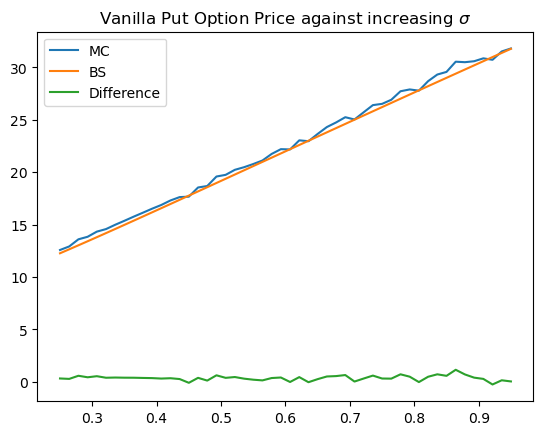

In [119]:
#Put option - Vega
mc_price = np.array([])
bs_price = np.array([])
sigma_list = np.linspace(0.25,0.95, 50)
for sigma in sigma_list:
    S = 100 #stock price S_{0}
    K = 110 # strike
    T = 1/2 # time to maturity
    r = 0.03 # risk free risk in annual %
    # sigma = 0.25 # annual volatility in %
    mc_step_count = 100 # time steps
    simulation_count = 10000 # number of trials

    mc_price = np.append(mc_price, MC_pricing(S, T, K, r, sigma, mc_step_count, simulation_count, type='put'))
    bs_price = np.append(bs_price, black_scholes_price(S, T, K, r, sigma, type = 'put'))
    
plt.plot(sigma_list, mc_price, label = 'MC')
plt.plot(sigma_list, bs_price, label = "BS")
plt.plot(sigma_list, (mc_price - bs_price), label = 'Difference')
plt.legend()
plt.title(r"Vanilla Put Option Price against increasing $\sigma$")
plt.show()
   

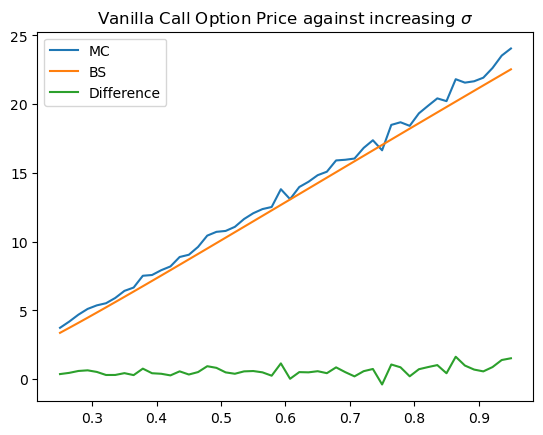

In [109]:
#Call option - Vega
mc_price = np.array([])
bs_price = np.array([])
sigma_list = np.linspace(0.25,0.95, 50)
for sigma in sigma_list:
    S = 100 #stock price S_{0}
    K = 110 # strike
    T = 1/2 # time to maturity
    r = 0.03 # risk free risk in annual %
    # sigma = 0.25 # annual volatility in %
    mc_step_count = 100 # time steps
    simulation_count = 10000 # number of trials

    mc_price = np.append(mc_price, MC_pricing(S, T, K, r, sigma, mc_step_count, simulation_count, type='call'))
    bs_price = np.append(bs_price, black_scholes_price(S, T, K, r, sigma, type = 'call'))
    
plt.plot(sigma_list, mc_price, label = 'MC')
plt.plot(sigma_list, bs_price, label = "BS")
plt.plot(sigma_list, (mc_price - bs_price), label = 'Difference')
plt.legend()
plt.title(r"Vanilla Call Option Price against increasing $\sigma$")
plt.show()
   

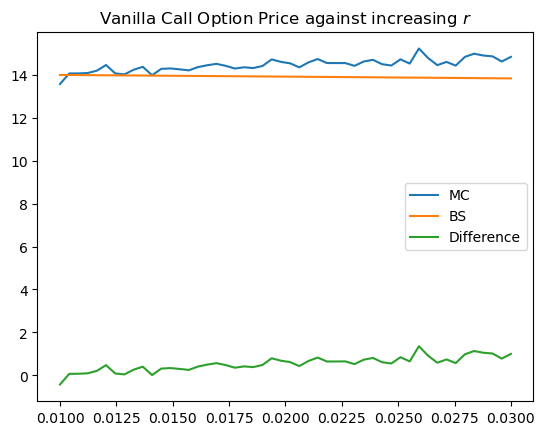

In [118]:
#Call option - Rho
mc_price = np.array([])
bs_price = np.array([])
r_list = np.linspace(0.01,0.03, 50)
for r in r_list:
    S = 120 #stock price S_{0}
    K = 110 # strike
    T = 1/2 # time to maturity
    # r = 0.03 # risk free risk in annual %
    sigma = 0.25 # annual volatility in %
    mc_step_count = 100 # time steps
    simulation_count = 10000 # number of trials

    mc_price = np.append(mc_price, MC_pricing(S, T, K, r, sigma, mc_step_count, simulation_count, type='call'))
    bs_price = np.append(bs_price, black_scholes_price(S, T, K, r, sigma, type = 'call'))
    
plt.plot(r_list, mc_price, label = 'MC')
plt.plot(r_list, bs_price, label = "BS")
plt.plot(r_list, (mc_price - bs_price), label = 'Difference')
plt.legend()
plt.title(r"Vanilla Call Option Price against increasing $r$")
plt.show()
   

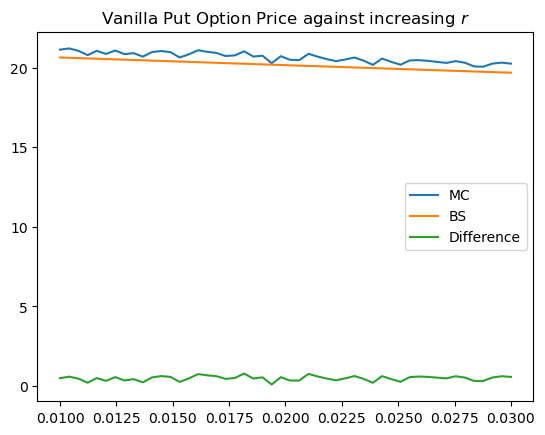

In [115]:
#Put option - Rho
mc_price = np.array([])
bs_price = np.array([])
r_list = np.linspace(0.01,0.03, 50)
for r in r_list:
    S = 90 #stock price S_{0}
    K = 110 # strike
    T = 1/2 # time to maturity
    # r = 0.03 # risk free risk in annual %
    sigma = 0.25 # annual volatility in %
    mc_step_count = 100 # time steps
    simulation_count = 10000 # number of trials

    mc_price = np.append(mc_price, MC_pricing(S, T, K, r, sigma, mc_step_count, simulation_count, type='put'))
    bs_price = np.append(bs_price, black_scholes_price(S, T, K, r, sigma, type = 'put'))
    
plt.plot(r_list, mc_price, label = 'MC')
plt.plot(r_list, bs_price, label = "BS")
plt.plot(r_list, (mc_price - bs_price), label = 'Difference')
plt.legend()
plt.title(r"Vanilla Put Option Price against increasing $r$")
plt.show()
   

# Section 2: Comparision of Pricing Models' predictions with data 


IV volatility is obtained by 'inverting' the Black Scholes formula to get a volatility value for a given option price. Therefore, it would be circular to input IV data into the BS pricing model to get option price estimates.

Rather it might be more intersting to plot the price obtained from the MC model, with the IV as it's input and compare this to the actual option price data. I would expect a close alignment between the two values. 

For starters, I'll focus on call options, and take $\text{Mid Price} = (\text{Ask Price} + \text{Bid Price})/2$  as an estimate of option price.

From [historical data](https://www.macrotrends.net/2016/10-year-treasury-bond-rate-yield-chart), it appears that the 10 year treasury rate was between 1.5 and 3.5% from 2021 to 2023. This is an extremely crude estimate, but for the sake of this exercise, I'll use this to approximate the risk free rate to be around 2.5%.

Additionally, as MC simulations are computationally expensive, I'll restrict this exercise to an expiry date with the less than 200 options. (See Section 3)

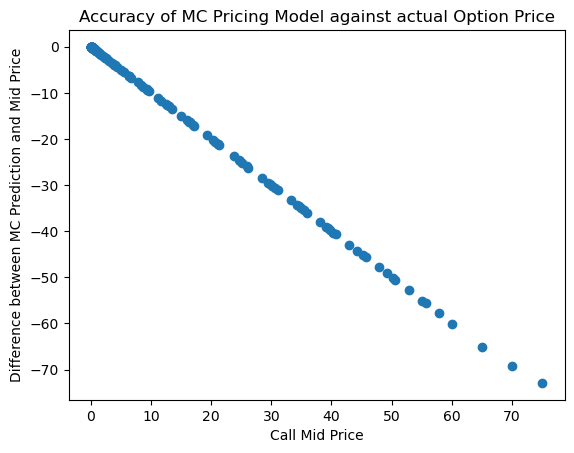

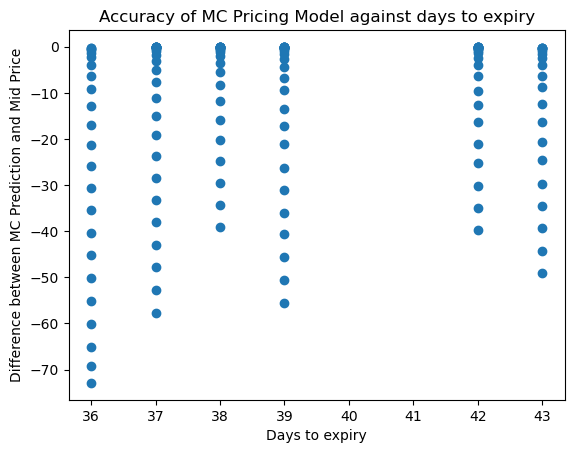

In [236]:
df_chain[' [C_MID_PRICE]'] = (df_chain[' [C_ASK]'] + df_chain[' [C_BID]'])/2

df_chain_truncated = df_chain.loc[(df_chain[' [EXPIRE_DATE]'] == '2022-05-06 ')].copy()

df_chain_truncated['[MC_Prediction]'] = df_chain_truncated.apply(
    lambda row: MC_pricing(
        row[' [C_MID_PRICE]'], 
        row[' [DTE]']/365, 
        row[' [STRIKE]'], 
        0.025,  # risk-free rate
        row[' [C_IV]'], 
        100,    # time steps
        1000,   # number of simulations
        type='call'
    ), axis=1
)

plt.scatter( df_chain_truncated[' [C_MID_PRICE]'], (df_chain_truncated['[MC_Prediction]'] - df_chain_truncated[' [C_MID_PRICE]']))
plt.xlabel("Call Mid Price")
plt.ylabel("Difference between MC Prediction and Mid Price")
plt.title("Accuracy of MC Pricing Model against actual Option Price")
plt.show()

plt.scatter( df_chain_truncated[' [DTE]'], (df_chain_truncated['[MC_Prediction]'] - df_chain_truncated[' [C_MID_PRICE]']))
plt.xlabel("Days to expiry")
plt.ylabel("Difference between MC Prediction and Mid Price")
plt.title("Accuracy of MC Pricing Model against days to expiry")
plt.show()

It can be seen that the deviation between option prices appears to increase with the mid price. In general, it appears as though the MC model underestimates the option price. This could possibly indicative of the model not capturing risk premiums and dividends (which this analysis ignored).

One would also expect the MC model to underperform more as the days to expiry increases, since the greater uncertainty invovled. But there doesn't appear to be any such trend observed.

# Section 3: Plotting of volatility smiles/surfaces

The data obtained is rather noisy, therefore I first sought to determine the frequency distribution of the expiry dates. I wanted to avoid further data processing for the time being therefore I chose an expiry date with the lowest number of data points so as to see a clearer trend.

In [161]:
df_chain[" [EXPIRE_DATE]"].value_counts()

 [EXPIRE_DATE]
2022-06-17    22158
2022-01-21    20992
2022-09-16    20742
2023-01-20    15145
2023-03-17    14707
              ...  
2022-05-06      144
2022-07-29      111
2022-07-22      106
2023-05-12       83
2022-05-13       16
Name: count, Length: 135, dtype: int64

Setting `2022-05-13` as the expiry date gave fairly smooth volatility smiles. However, there were far too few data points to get a good volatility surface plot out. A next step would be to apply outlier removal and smoothing to reduce the noise for data subset with many more data points, and invariably more noise.

## Volatility Smiles

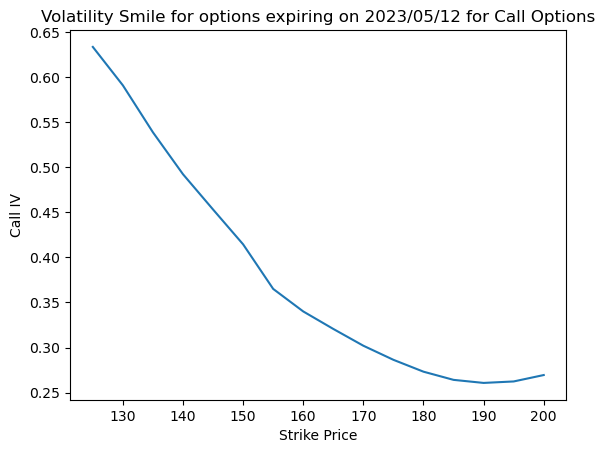

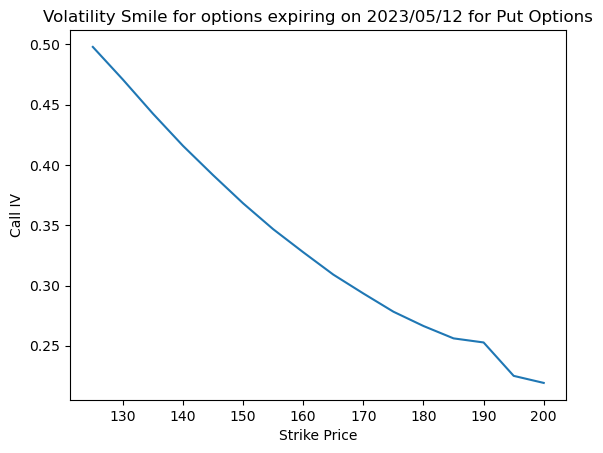

In [197]:
df_chain_1 = df_chain.loc[(df_chain[' [EXPIRE_DATE]'] == '2022-05-13 ')]
df_chain_1.sort_values(by = ' [STRIKE]')

plt.title("Volatility Smile for options expiring on 2023/05/12 for Call Options")
plt.plot(df_chain_1[' [STRIKE]'], df_chain_1[' [C_IV]']  )
plt.xlabel("Strike Price")
plt.ylabel("Call IV")
plt.show()

plt.title("Volatility Smile for options expiring on 2023/05/12 for Put Options")
plt.plot(df_chain_1[' [STRIKE]'], df_chain_1[' [P_IV]']  )
plt.xlabel("Strike Price")
plt.ylabel("Call IV")
plt.show()

# df_chain_1.head()

## Volatility Surface

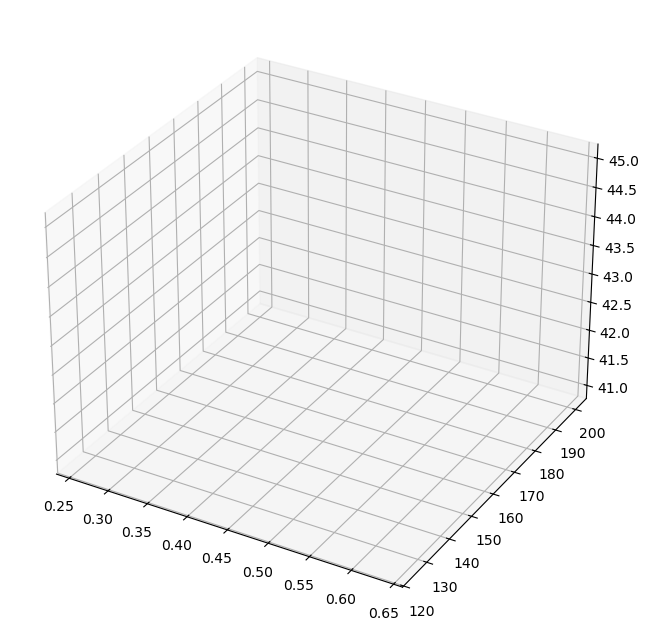

In [198]:
# This graph was plotted with reference to [3]
call_volatility_surface = (df_chain_1[[' [DTE]', ' [STRIKE]', ' [C_IV]']].pivot_table(values = ' [C_IV]', index = ' [STRIKE]', columns = ' [C_IV]'))

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

x, y, z = call_volatility_surface.columns.values, call_volatility_surface.index.values, call_volatility_surface.values

X, Y = np.meshgrid(x,y)

ax.plot_surface(X,Y, z)


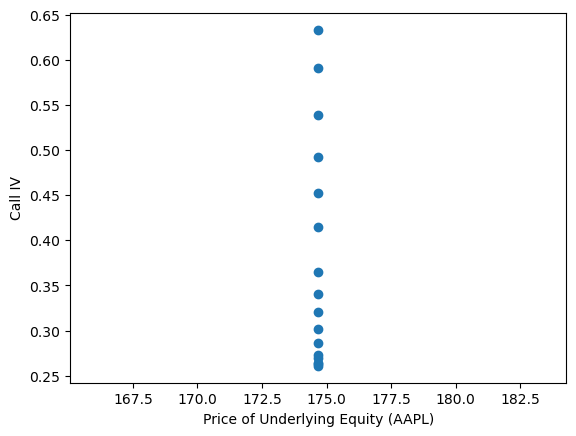

In [204]:
#Plot of IV against price of underlying equity
plt.scatter(df_chain_1[' [UNDERLYING_LAST]'], df_chain_1[' [C_IV]'])
plt.xlabel("Price of Underlying Equity (AAPL)")
plt.ylabel("Call IV")
plt.show()

## Analysis
* From theory [1], we expect that the volatility smile should appear more like a 'smirk' due to a negative correlation between volatility and equity prices.
* Here, volatility ostensibly refers to a measure uncertainty in the price, as opposed to IV which is a transformation of option prices. Plotting IV against equity prices therefore doesn't yield any negative correlation.

# References
[1] : John C. Hull: Options, Futures and Other Derivatives

[2] : https://www.codearmo.com/blog/pricing-options-monte-carlo-simulation-python

[3] : https://www.pyquantnews.com/the-pyquant-newsletter/build-an-implied-volatility-surface-with-python